In [ ]:
import os
from pathlib import Path
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.ndimage import gaussian_filter

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Anomaly_detection/Data/MvTec"

Mounted at /content/drive


In [ ]:
# Load wide-ResNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.cuda()
model.eval()

In [ ]:
# Set hooks for outputs
def get_activation(name):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = torch.tensor([])
        activation[name] = torch.cat((activation[name], output.detach().cpu()))
    return hook


model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))

### Normal Dataset

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.data = image_paths

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx])

        if self.transform:
            image = self.transform(image)

        return image

transform = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# MVTec metal_nut class
train_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/train/good").glob("./*.png")))
test_paths = list(sorted(Path(DATA_ROOT + "/metal_nut/test/color").glob("./*.png")))[:3] + list(sorted(Path(DATA_ROOT + "/metal_nut/test/good").glob("./*.png")))[:2]

train_outputs = OrderedDict([('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([ ('layer2', []), ('layer3', [])])

trainset = BrainDataset(train_paths, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = BrainDataset(test_paths, transform=transform)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

### Fetures of normal

In [ ]:
activation = {}
with torch.no_grad():
  for x in tqdm(train_dataloader, position =0):
      model(x.cuda())

for layer in ['layer2', 'layer3']:
    train_outputs[layer] = activation[layer]

for layer in ['layer2', 'layer3']:
    print(train_outputs[layer].size())

100%|██████████| 7/7 [00:32<00:00,  4.58s/it]

torch.Size([220, 512, 28, 28])
torch.Size([220, 1024, 14, 14])


### Features of abnormal

In [ ]:
activation = {}
with torch.no_grad():
  for x in tqdm(test_dataloader, position =0):
      model(x.cuda())

for layer in ['layer2', 'layer3']:
    test_outputs[layer] = activation[layer]

for layer in ['layer2', 'layer3']:
    print(test_outputs[layer].size())

100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

torch.Size([5, 512, 28, 28])
torch.Size([5, 1024, 14, 14])


### Understand how unfold works with examples

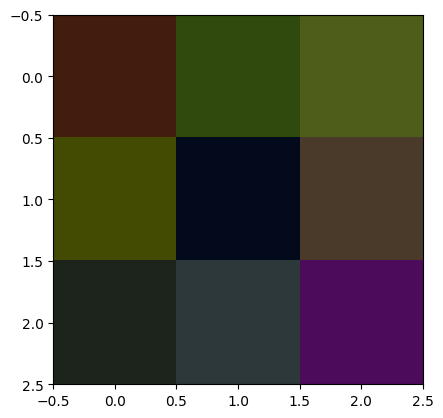

dim 2 padded   torch.Size([1, 3, 5, 3])
dim 2 unfolded torch.Size([1, 3, 3, 3, 3])
dim 3 padded   torch.Size([1, 3, 3, 5, 3])
dim 3 unfolded torch.Size([1, 3, 3, 3, 3, 3])


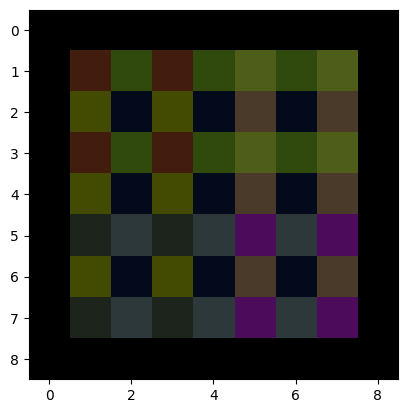

In [ ]:
x = torch.from_numpy((100*np.random.random((1, 3, 3, 3))).astype(np.uint8))

plt.imshow(x.squeeze(0).permute(1, 2, 0))
plt.show()
kernel_size = 3
x = F.pad(x, (0, 0, kernel_size//2, kernel_size//2))
print("dim 2 padded  ", x.size())
x = x.unfold(2, kernel_size, 1)
print("dim 2 unfolded", x.size())
x = F.pad(x, (0, 0, kernel_size//2, kernel_size//2, 0, 0))
print("dim 3 padded  ", x.size())
x = x.unfold(3, kernel_size, 1)
print("dim 3 unfolded", x.size())

x = torch.squeeze(x.permute([0, 2, 3, 1, 4, 5]))

plt.imshow(x.permute(2, 0, 3, 1, 4).reshape(3, 3*kernel_size, 3*kernel_size).permute(1, 2, 0))
plt.show()

og torch.Size([1, 3, 830, 830])
dim 2 padded   torch.Size([1, 3, 958, 830])
dim 2 unfolded torch.Size([1, 3, 21, 830, 128])
dim 3 padded   torch.Size([1, 3, 21, 958, 128])
dim 3 unfolded torch.Size([1, 3, 21, 28, 128, 128])
move channel and squeeze torch.Size([21, 28, 3, 128, 128])

example patch


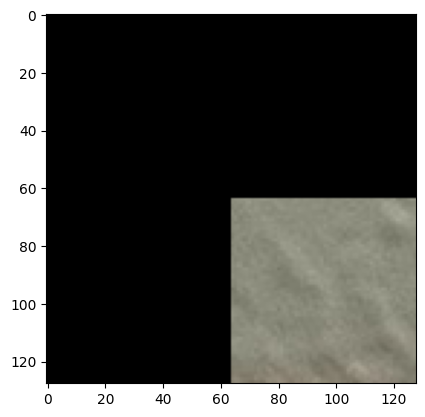

patched image


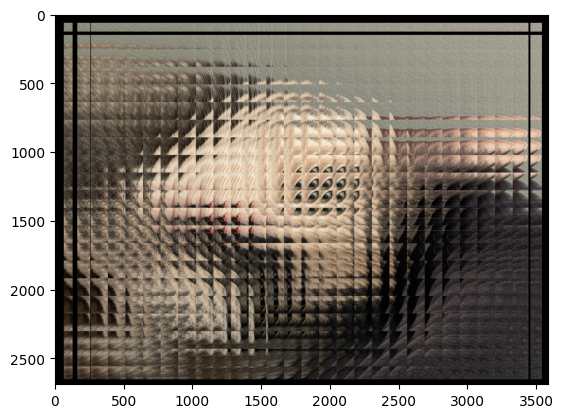

In [ ]:
x = transforms.ToTensor()(Image.open("IMG_2964.jpeg")).unsqueeze(0)
print("og", x.size()) # [1, 3, 830, 830]

# Assuming kernel is odd, pad kernel//2.
kernel_size = 128
x = F.pad(x, (0, 0, kernel_size//2, kernel_size//2))
print("dim 2 padded  ", x.size())
x = x.unfold(2, kernel_size, step=40)
print("dim 2 unfolded", x.size())
x = F.pad(x, (0, 0, kernel_size//2, kernel_size//2, 0, 0))
print("dim 3 padded  ", x.size())
x = x.unfold(3, kernel_size, step=30)
print("dim 3 unfolded", x.size())

x = torch.squeeze(x.permute([0, 2, 3, 1, 4, 5]))
print("move channel and squeeze", x.size())
print()
print("example patch")
plt.imshow(x[0, 0].permute(1, 2, 0))
plt.show()

print("patched image")
plt.imshow(x.permute(2, 0, 3, 1, 4).reshape(3, x.size()[0]*kernel_size, x.size()[1]*kernel_size).permute(1, 2, 0))
plt.show()

### PatchCore
1. Interpolate and match H, W with largest H, W. <br>
2. Unfold and create patches <br>
3. Adaptive average pool and create locally aware patch features <br>
4. concatine features from different layers and adaptive average pool<br>

In [ ]:
print(test_outputs["layer2"].size())
print(test_outputs["layer3"].size())

torch.Size([5, 512, 28, 28])
torch.Size([5, 1024, 14, 14])


In [ ]:
patched_agg_train = []
patched_agg_test = []

print("Here, the steps are")
print()
print("1. H x W -> H_j x W_j 2D interpolation")
print("2. patchify")
print("3. 1D interpolation of C*k*k to pre-defined dim")
print("4. concatinate layers and 1D interpolation to predefined-dim")
print()
print("but in the paper's repo they seem to do 2 and then 1.")
print()

k = 3
m = nn.AdaptiveAvgPool2d(train_outputs['layer2'].size()[2])


for output, patched_agg in [(train_outputs, patched_agg_train), (test_outputs, patched_agg_test)]:
  for layer in ['layer2', 'layer3']:
    # print("---")

    # print("B x C x H x W")
    # print(list(output[layer].size()))
    # print()

    x = F.interpolate(output[layer],
                size=(output['layer2'].size()[-2], output['layer2'].size()[-1]),
                mode="bilinear",
                align_corners=False,
            )

    # print("B x C x H_j x W_j")
    # print(list(x.size()))
    # print()

    # print("**interpolation H x W -> H_j x W_j completed**")
    # print()

    # Pad to make output the same size
    x = F.pad(x, (0, 0, k//2, k//2))

    # print("k//2:", k//2)
    # print()

    # print("B x C x (H_j + 2 * k//2) x W_j")
    # print(list(x.size()))
    # print()

    x = x.unfold(2, k, step=1)

    # print("B x C x H_j x W_j x k")
    # print(list(x.size()))
    # print()

    x = F.pad(x, (0, 0, k//2, k//2, 0, 0))

    # print("B x C x H_j x (W_j + 2 * k//2) x k")
    # print(list(x.size()))
    # print()

    x = x.unfold(3, k, step=1)
    # print("B x C x H_j x W_j x k x k")
    # print(list(x.size()))
    # print()

    # print("**patch creation completed**")
    # print()

    x = x.permute([0, 2, 3, 1, 4, 5])
    # print("B x H_j x W_j x C x k x k")
    # print(list(x.size()))
    # print()

    x = x.reshape(x.size()[0], -1, *x.size()[-3:])
    # print("B x (H_j*W_j) x C x k x k")
    # print(list(x.size()))
    # print()

    x = x.reshape(-1, *x.size()[-3:])
    # print("(B*H_j*W_j) x C x k x k")
    # print(list(x.size()))
    # print()

    x = x.reshape(len(x), 1, -1)
    # print("(B*H_j*W_j) x 1 x (C*k*k)")
    # print(list(x.size()))
    # print()

    x = (F.adaptive_avg_pool1d(x, 1024)).squeeze()
    # print("(B*H_j*W_j) x 1024")
    # print(list(x.size()))
    # print()

    # print("**locally aware patch features created**")
    # print()
    # Aggregate with adaptive average pool

    patched_agg.append(x)

# performing what is done in "Aggregator" class of paper
memory_bank = F.adaptive_avg_pool1d(torch.cat(patched_agg_train, dim=-1), 1024)
test_feats = F.adaptive_avg_pool1d(torch.cat(patched_agg_test, dim=-1), 1024).reshape(testset.__len__(), -1, 1024)

print()
print("memory bank M size:")
print(list(memory_bank.size()))
print()

print("-- steps 1-4 completed --")

Here, the steps are

1. H x W -> H_j x W_j 2D interpolation
2. patchify
3. 1D interpolation of C*k*k to pre-defined dim
4. concatinate layers and 1D interpolation to predefined-dim

but in the paper's repo they seem to do 2 and then 1.


memory bank M size:
[172480, 1024]

-- steps 1-4 completed --


### Coreset Sampling (k-center problem) <br>
"choose b center
points such that the largest distance between a data
point and its nearest center is minimized"<br>
ApproximateGreedyCoresetSampler in PatchCore Github

In [ ]:
# based on PatchCore  github
# Compute the distance between the row vectors of X and a single vector y.
def matrix_rows_vs_vec_dist(X, y):

    ### B x 1 x C  @ B x C x 1 (vec inner product) => B x 1 x 1
    X_times_X = X.unsqueeze(1).bmm(X.unsqueeze(2)).reshape(-1, 1)
    y_times_y = y.unsqueeze(1).bmm(y.unsqueeze(2)).reshape(-1, 1).permute(1, 0)
    X_times_y = X.mm(y.T)

    return X_times_X + y_times_y - 2  * X_times_y

In [ ]:
# Greedy approximate algorithm for k-centers problem:
def greedy_k_center(M, k):
  centers = []
  # Choose random center
  cur_center = np.random.randint(len(M))
  centers.append(cur_center)

  # Distance bwtween all points in M and initial center
  dist_to_closest_ctr = matrix_rows_vs_vec_dist(M, M[cur_center].unsqueeze(0))

  for i in tqdm(range(k)):
    # Find point farthest from current ind
    new_center = torch.argmax(torch.squeeze(dist_to_closest_ctr))

    # record new point
    centers.append(new_center)

    # compute distance between all points and y_new
    dist_to_new_center = matrix_rows_vs_vec_dist(M, M[new_center].unsqueeze(0))

    # dist to closest center in the list of centers
    dist_to_closest_ctr = torch.min(torch.cat((dist_to_closest_ctr, dist_to_new_center), dim=-1), dim=-1).values.unsqueeze(1)

  return centers


In [ ]:
# n: reduction factor
n = 0.01

with torch.no_grad():
  # psi: Random Linear Projection

  psi = torch.nn.Linear(memory_bank.size()[-1], 128, bias=False).cuda().eval()
  M_proj = psi(memory_bank.cuda())

  centers = greedy_k_center(M_proj, int(n * len(memory_bank)))

100%|██████████| 1724/1724 [00:02<00:00, 714.26it/s]


In [ ]:
Mc = memory_bank[centers]
print("-- Memory bank coreset created --")

-- Memory bank coreset created --


### Check our greedy k-center algorithm

100%|██████████| 300/300 [00:00<00:00, 4869.55it/s]


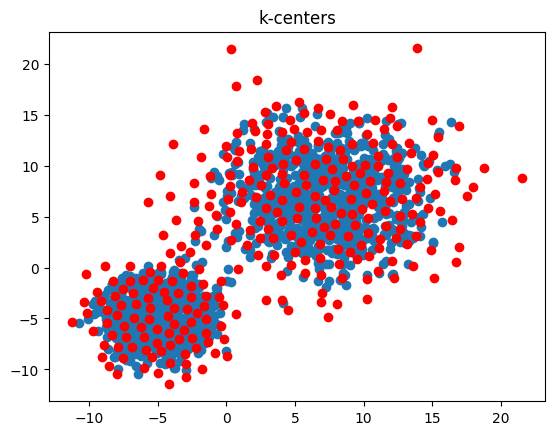

In [ ]:
N = 1000
points_2d = torch.from_numpy(np.concatenate((np.random.normal(loc=7, scale=4, size=(N, 2)), np.random.normal(loc=-5, scale=2, size=(N, 2)))))

inds = torch.tensor(greedy_k_center(points_2d, 300))
mask = np.full(2*N, True, dtype=bool)
mask[inds] = False

plt.scatter(points_2d[mask][:, 0], points_2d[mask][:, 1])
plt.scatter(points_2d[inds][:, 0], points_2d[inds][:, 1], color="red")
plt.title("k-centers")
plt.show()

In [ ]:
print(Mc.size())
print(test_feats.size())

torch.Size([1725, 1024])
torch.Size([5, 784, 1024])


### Create Score Map

In [ ]:
score_map_list = []
for i in range(len(test_feats)):
  argmin_m = []
  min_m = []
  for y in tqdm(test_feats[i]):
    X = Mc
    y = y.unsqueeze(0)

    min_m.append(torch.min(matrix_rows_vs_vec_dist(X, y)))
    argmin_m.append(torch.argmin(matrix_rows_vs_vec_dist(X, y)))

  m_test_star_ind = np.argmax(min_m)
  m_star_ind = argmin_m[m_test_star_ind]

  s_star = torch.sqrt(torch.sum((test_feats[i][m_test_star_ind] - Mc[m_star_ind])**2))

  # b nearest patch features in Mc of test patch feature m_test_star_ind
  m_test_vec = test_feats[i][m_test_star_ind].unsqueeze(0)

  dist = matrix_rows_vs_vec_dist(Mc, m_test_vec)

  top_b = torch.topk(torch.squeeze(dist), 5).indices
  neighbor_vects = Mc[top_b]

  numerator = torch.exp(s_star)
  denominator = torch.sum(torch.exp(torch.sqrt(torch.sum((neighbor_vects - m_test_vec) ** 2, dim=-1))))

  s = (1-numerator/denominator) * s_star

  score_map = torch.reshape(torch.tensor(min_m), (28, 28))

  score_map_list.append(score_map)


map_interpolated = torch.zeros((len(score_map_list), 224, 224))
for item in range(len(score_map_list)):
    map_interpolated[item] = F.interpolate(score_map_list[item].unsqueeze(0).unsqueeze(0), size=224,mode='bilinear', align_corners=False)

# for item in map_interpolated:
#   plt.imshow(item, vmin=torch.min(map_interpolated), vmax=torch.max(map_interpolated))
#   plt.show()


100%|██████████| 784/784 [00:05<00:00, 140.60it/s]


In [ ]:
def overlay_heatmap_on_image(img, heatmap, ratio_img=0.5):
    img = img.astype(np.float32)

    heatmap = 1 - np.clip(heatmap, 0, 1)
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32)

    overlay = (img * ratio_img) + (heatmap * (1 - ratio_img))
    overlay = overlay.astype(np.uint8)
    overlay = np.clip(overlay, 0, 255)
    return overlay


---
defect


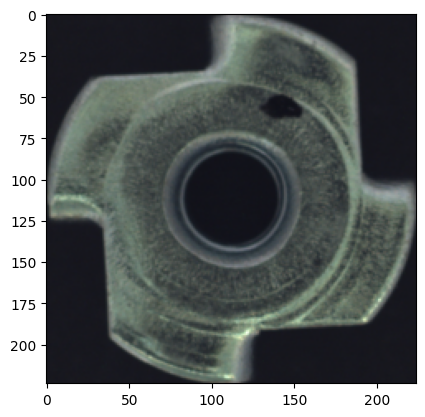

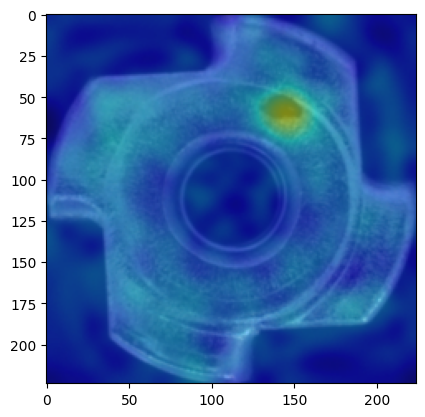

---
defect


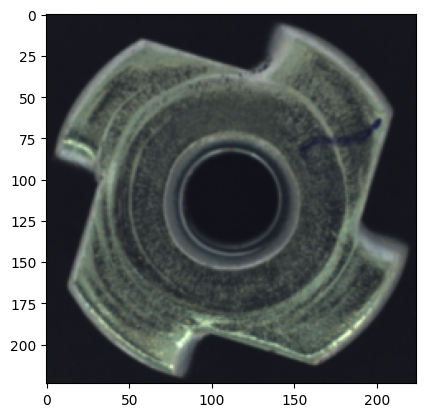

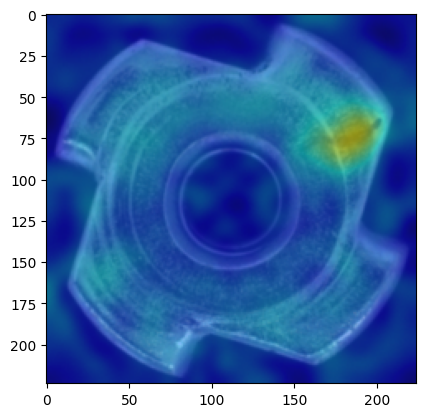

---
defect


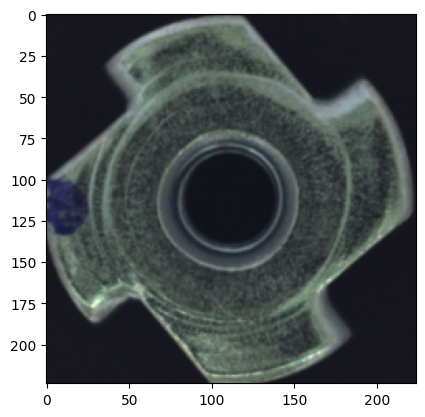

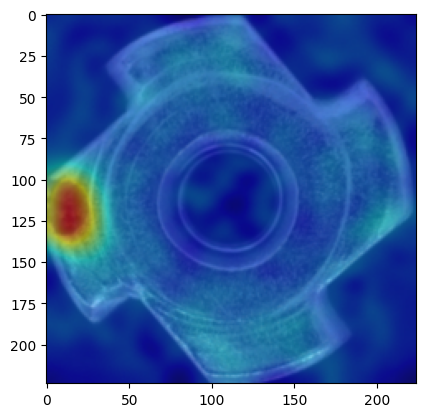

---
good


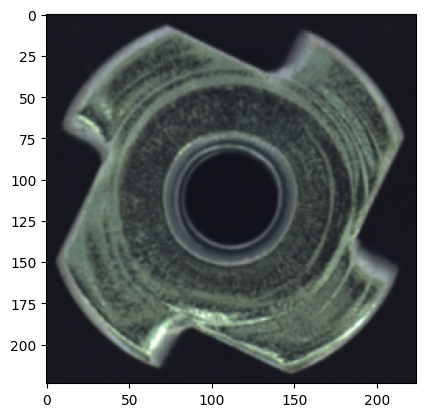

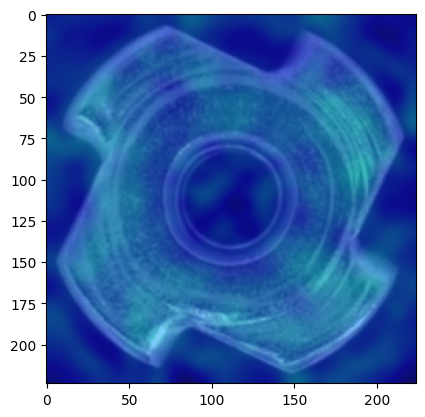

---
good


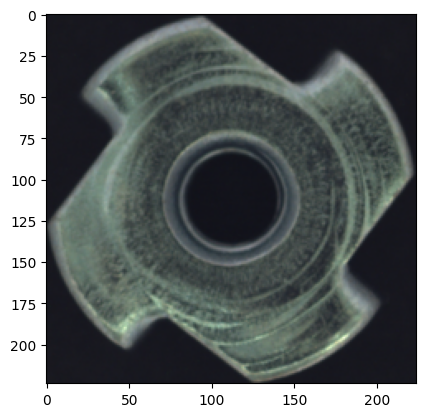

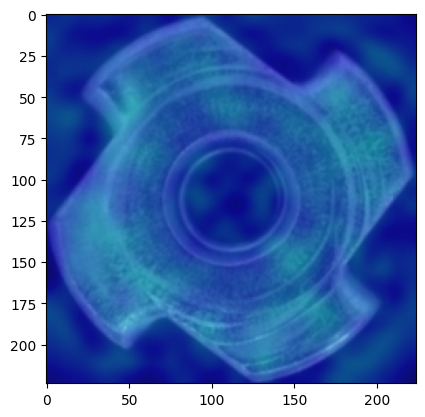

In [ ]:
for item in range(len(map_interpolated)):
    print("---")
    if item < 3:
      print("defect")
    else:
      print("good")
    score_map_ = map_interpolated[item]

    score_map_ = gaussian_filter(score_map_, sigma=4)

    score_map_ = score_map_ - torch.min(map_interpolated).item()
    score_map_ = score_map_ / torch.max(map_interpolated).item()

    # threshold score map

    col_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ])

    col_anomaly = col_preprocess(Image.open(test_paths[item])).permute(1, 2, 0).numpy() * 255

    plt.imshow(np.clip(col_anomaly.astype(np.uint8), 0, 255))
    plt.show()

    plt.imshow(overlay_heatmap_on_image(col_anomaly, score_map_, 0.5))
    plt.show()

References: <br>
https://tech.anytech.co.jp/entry/2023/03/24/100000 <br>
https://github.com/amazon-science/patchcore-inspection/tree/b64be4734cb8295bfbadccf4f6a036b266181e57/src/patchcore <br>
https://github.com/amazon-science/patchcore-inspection/issues/21#issuecomment-1148390290 <br>
https://www.cs.umd.edu/class/fall2017/cmsc451-0101/Lects/lect08-greedy-k-center.pdf <br>
https://github.com/amazon-science/patchcore-inspection/issues/4#issuecomment-1123763551